In [ ]:
import os

from model import traverse_apply, to_float

os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np
import matplotlib.pyplot as plt
from cebra import CEBRA

import torch
import cebra.integrations.plotly

def figure_3d(title=''):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection='3d')
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(title)
    return ax


/home/chongjg/miniconda3/envs/VLEM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### prepare cebra model

In [3]:
output_dimension = 3
cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1.12,
                    output_dimension=output_dimension,
                    max_iterations=2000,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

#### load data

In [ ]:
output_dir = './outputs/EpiGibson-distribute-0/'
save_dir = output_dir + 'results/'
os.makedirs(save_dir, exist_ok=True)

step_id = 5000

outputs = traverse_apply(torch.load(output_dir + f'outputs-EMmodel-{step_id}.pt'), to_float)
test_data = torch.load(output_dir + f'test_data.pt')

annot_where_text = np.load(output_dir + 'annot_where_text.npy')[:,0,0]
color_dict = {
    'living_room' : 'red',
    'kitchen' : 'orange',
    'bathroom' : 'cyan',
    'bedroom' : 'gold',
    'corridor' : 'green',
    'dining_room' : 'black',
    'living_room_2' : 'blue',
}
annot_color = np.array([color_dict[item] for item in annot_where_text])


#### load VLEM model

In [6]:
from model import EMModel

mode = 'distribute'

attribute_list = ["whole-event"] if mode == 'merge' else ["where", "what", "when"]

model = EMModel(
    vision_input_size=1024,
    text_input_size=1024,
    # Event
    attribute_list=attribute_list,
    event_size=1024*(3 if mode == 'merge' else 1),
    # working memory
    wm_size=256,
    num_slots=7,
    # Entorihnal
    ento_size=1024,
    # episodic memory
    em_size=1024 * (3 if mode == 'merge' else 1),
    additional_iteration=2,
    drop=0.,
    # plan
    plan_size=1024,
    mode=mode,
).cuda()

model.load_state_dict(torch.load(output_dir + f'checkpoint-{step_id}.pt'))

with torch.no_grad():
    sensory_input_inactivated = model.module_dict['sensory input'].wm2input(torch.randn(1000, model.module_dict['sensory input'].wm_size, device='cuda')).cpu()


 ----------- model configuration ----------- 
sensory input
  vision_input_size : 1024
  text_input_size : 1024
event
  attribute_list : ['where', 'what', 'when']
  event_size : 1024
working memory
  wm_size : 256
  num_slots : 7
entorhinal
  ento_size : 1024
episodic memory
  em_size : 1024
  additional_iteration : 2
  drop : 0.0
plan
  plan_size : 1024
mode
  mode : distribute
loss scale
  dict : {}
 ----------- model configuration ----------- 



#### Working memory & sensory input prediction

In [ ]:
wm_save_dir = save_dir + 'wm/'
os.makedirs(wm_save_dir, exist_ok=True)

sensory_input = test_data['sensory_input']
sensory_input_prediction = outputs['all sensory input prediction']

annot = test_data['annot_action'][0]

sensory_input = sensory_input[:, 0]
sensory_input_prediction = sensory_input_prediction[:, 0]
num_slots = sensory_input_prediction.shape[1]

sensory_input_prediction = sensory_input_prediction.transpose(0, 1)

In [8]:
cebra_model.fit(torch.cat([sensory_input_prediction.flatten(0, 1), sensory_input_inactivated], 0))

cebra_sensory_input3 = cebra_model.transform(sensory_input)


pos: -0.8923 neg:  6.3676 total:  5.4752 temperature:  1.1200: 100%|██████████| 2000/2000 [00:11<00:00, 171.44it/s]


In [9]:
cebra_sensory_input_predict3 = np.concatenate([cebra_model.transform(sensory_input_prediction[i]) for i in range(num_slots)], 0)
cebra_sensory_input_predict3 = cebra_sensory_input_predict3.reshape(num_slots, -1, output_dimension)

cebra_inactivate_predict3 = cebra_model.transform(sensory_input_inactivated)

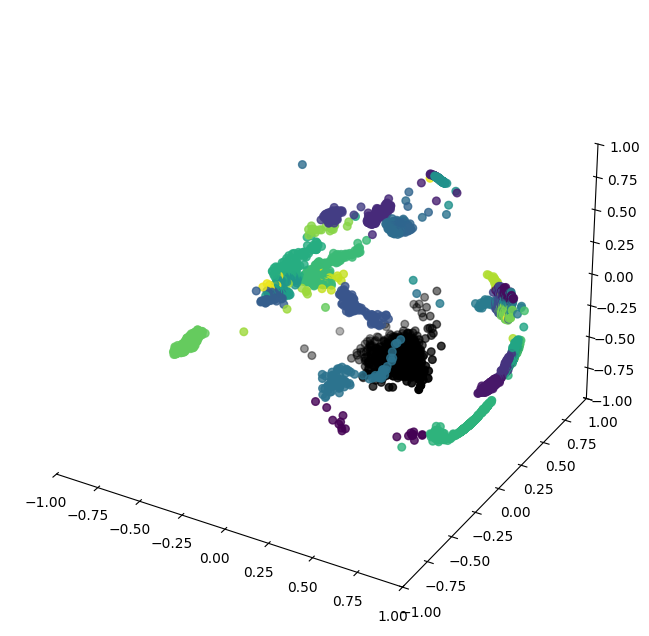

In [10]:
ax = figure_3d()
ax.scatter(cebra_inactivate_predict3[:,0],
        cebra_inactivate_predict3[:,1],
        cebra_inactivate_predict3[:,2],
        c=['black'] * cebra_inactivate_predict3.shape[0],
        s=30)
ax.scatter(cebra_sensory_input3[:,0],
        cebra_sensory_input3[:,1],
        cebra_sensory_input3[:,2],
        c=annot,
        s=30,
        alpha=0.8)
plt.savefig(wm_save_dir + 'wm-overview.png', dpi=150)
plt.show()

In [ ]:
interval = 10
for t in range(0, min(len(cebra_sensory_input3), 500*interval), interval):
    ax = figure_3d()
    ax.scatter(cebra_sensory_input3[t:t+interval,0],
                cebra_sensory_input3[t:t+interval,1],
                cebra_sensory_input3[t:t+interval,2],
                c=['red'] * interval,
                cmap='coolwarm',
                alpha=0.1,
                s=50)
    ax.scatter(cebra_inactivate_predict3[:,0],
                cebra_inactivate_predict3[:,1],
                cebra_inactivate_predict3[:,2],
                c=['gray'] * cebra_inactivate_predict3.shape[0],
                cmap='coolwarm',
                alpha=0.1,
                s=50)
    for i in range(num_slots):
        ax.scatter(cebra_sensory_input_predict3[i,t:t+interval,0],
                cebra_sensory_input_predict3[i,t:t+interval,1],
                cebra_sensory_input_predict3[i,t:t+interval,2],
                c=['blue'] * interval,
                cmap='coolwarm',
                s=30)
    plt.savefig(wm_save_dir + f'wm-{t}.png', dpi=150)
    plt.close()

In [ ]:
from PIL import Image
import cv2

str = 'wm'

wm_save_dir + f'wm-{t}.png'
image_folder = wm_save_dir
video_name = wm_save_dir + f'{str}.mp4'

images = [f'{str}-{idx}.png' for idx in range(0, 5000, 10)]
img_pil = Image.open(os.path.join(image_folder, images[0]))

width, height = img_pil.size

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 8, (width, height))

for image in images:
    img_path = os.path.join(image_folder, image)
    img_pil = Image.open(img_path)
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    video.write(img_cv)

cv2.destroyAllWindows()
video.release()

episodic memory & events

In [ ]:
em_save_dir = save_dir + 'em/'
os.makedirs(em_save_dir, exist_ok=True)

annot_what = test_data['annot'][0]
annot_where = test_data['annot_where'][0]

em = outputs['episodic memory']
em_target = outputs['episodic memory target']

cur_event = test_data['curEvent_target']
cur_event_prediction = outputs['event prediction']

attribute_list = ['where', 'what', 'when']

cur_event = {attribute:cur_event[attribute][:,0] for attribute in model.attribute_list}
cur_event_prediction = {attribute:cur_event_prediction[attribute][:,0] for attribute in attribute_list}

em = {attribute:em[attribute][:,0] for attribute in attribute_list}
em_target = {attribute:em_target[attribute][:,0] for attribute in attribute_list}

attribute = 'where'

annot = annot_what if attribute == 'what' else annot_where



In [14]:
cebra_model.fit(em[attribute])
cebra_em3 = cebra_model.transform(em[attribute])
cebra_em_target3 = cebra_model.transform(em_target[attribute])

pos: -0.8800 neg:  6.3713 total:  5.4913 temperature:  1.1200: 100%|██████████| 2000/2000 [00:07<00:00, 270.51it/s]


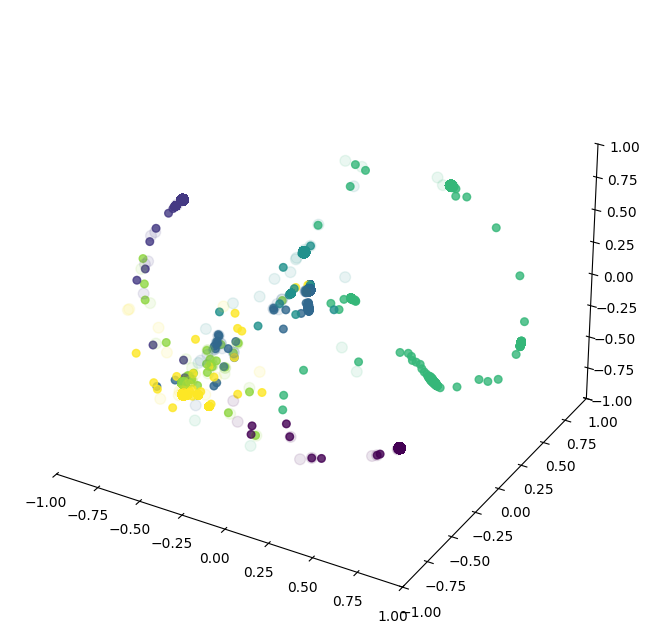

In [15]:
ax = figure_3d()
ax.scatter(cebra_em3[:,0],
        cebra_em3[:,1],
        cebra_em3[:,2],
        c=annot,
        s=30,
        alpha=0.8)
ax.scatter(cebra_em_target3[:,0],
        cebra_em_target3[:,1],
        cebra_em_target3[:,2],
        c=annot,
        s=60,
        alpha=0.1)
plt.savefig(em_save_dir + 'em-overview.png', dpi=150)
plt.show()

In [16]:
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_em3, embedding_labels=annot, title="CEBRA-Time", cmap = "rainbow", markersize=3)
fig.show()

<Figure size 500x500 with 0 Axes>

pos: -0.8853 neg:  6.3813 total:  5.4960 temperature:  1.1200: 100%|██████████| 2000/2000 [00:07<00:00, 268.89it/s]


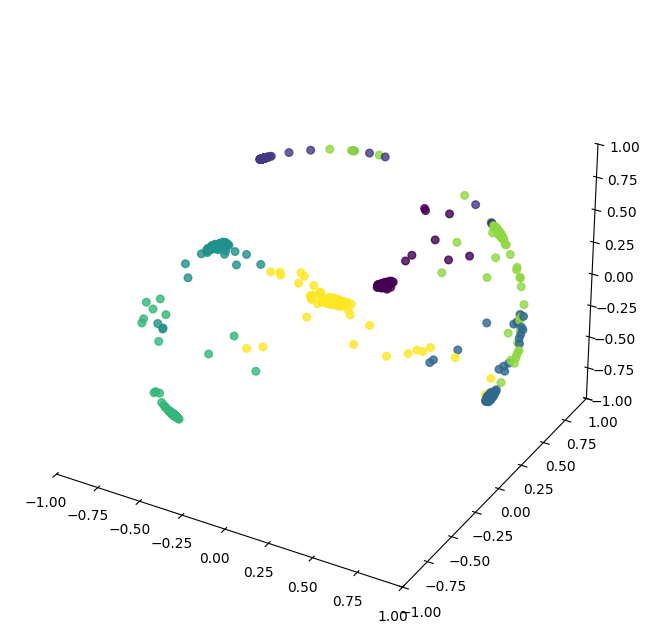

In [17]:

cebra_model.fit(cur_event_prediction[attribute])
cebra_cur_event3 = cebra_model.transform(cur_event[attribute])
cebra_cur_event_predict3 = cebra_model.transform(cur_event_prediction[attribute])

ax = figure_3d()
ax.scatter(cebra_cur_event_predict3[:,0],
        cebra_cur_event_predict3[:,1],
        cebra_cur_event_predict3[:,2],
        c=annot,
        s=30,
        alpha=0.8)
plt.savefig(em_save_dir + 'event-overview.png', dpi=150)
plt.show()

In [ ]:
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_cur_event_predict3, embedding_labels=annot_color, title="CEBRA-Time", markersize=4, dpi=1200)
fig.show()
fig.write_image('outputs/event-plot.png', scale=5)

<Figure size 6000x6000 with 0 Axes>

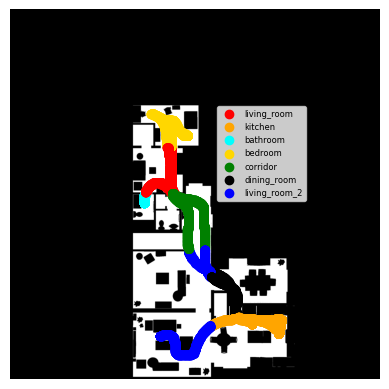

In [ ]:
map = cv2.imread('data/EpiGibson/floor_trav_no_door_0.png')
pos_list = np.load('data/EpiGibson/test/0001/map_pos_list.npy')[:-1]* 10
plt.figure()
plt.axis('off')
plt.imshow(map)
for c in color_dict.values():
    for i in range(len(pos_list)):
        if annot_color[i] == c:
            plt.scatter(pos_list[i:i+1,1], pos_list[i:i+1,0], color=annot_color[i:i+1])
            break
plt.legend(color_dict.keys(), bbox_to_anchor=(0.55, 0.75), fontsize=6)
plt.scatter(pos_list[:,1], pos_list[:,0], color=annot_color)
plt.savefig('outputs/map.png', dpi=600)